In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

In [2]:
from text_recognizer.datasets import EmnistDataset, EmnistLinesDataset, Transpose, construct_image_from_string, get_samples_by_character

In [3]:
emnist_lines = EmnistLinesDataset(train=True)

2020-08-11 19:26:46.938 | DEBUG    | text_recognizer.datasets.emnist_lines_dataset:_load_data:159 - EmnistLinesDataset loading data from HDF5...


In [4]:
def convert_y_label_to_string(y, emnist_lines=emnist_lines):
    return ''.join([emnist_lines.mapper(int(i)) for i in y])

412 We____________________________
new_______________________________
decided___________________________
indictment the 10000 bond was_____
of possessions and living plays___
Lillys____________________________
life______________________________
in circles making_________________
enlist____________________________


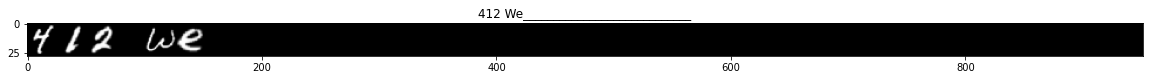

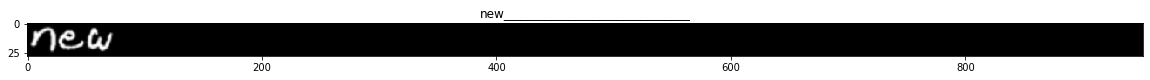

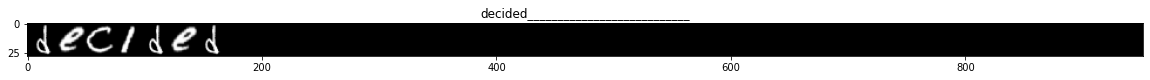

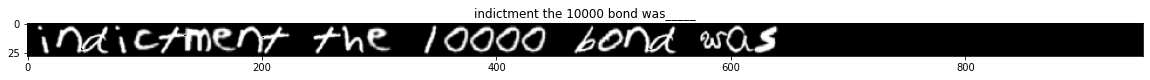

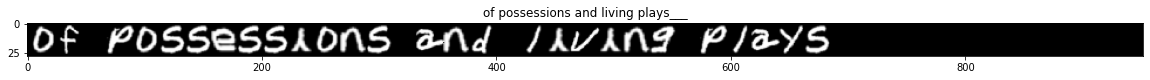

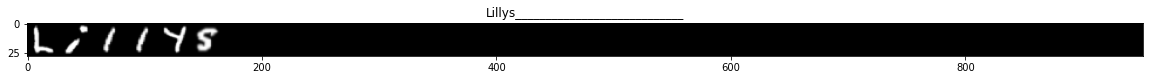

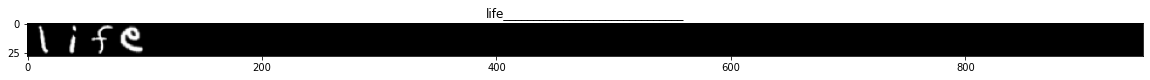

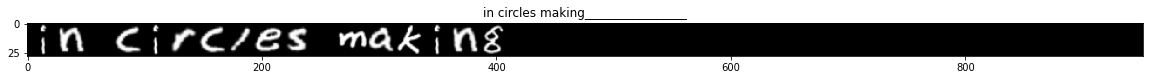

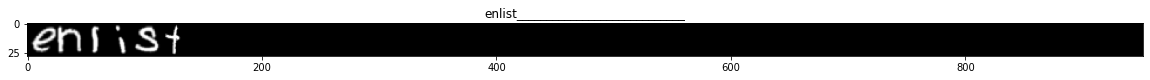

In [5]:
num_samples_to_plot = 9

for i in range(num_samples_to_plot):
    plt.figure(figsize=(20, 20))
    data, target = emnist_lines[i]
    sentence = convert_y_label_to_string(target.numpy()) 
    print(sentence)
    plt.title(sentence)
    plt.imshow(data.squeeze(0), cmap='gray')

In [6]:
data.shape

torch.Size([1, 28, 952])

In [7]:
from text_recognizer.networks.misc import sliding_window

In [8]:
data, target = emnist_lines[8]

In [9]:
data.shape

torch.Size([1, 28, 952])

In [10]:
target.shape

torch.Size([34])

In [11]:
patches = sliding_window(images=data.unsqueeze(0), patch_size=(28, 28), stride=(1, 14))

In [12]:
patches.shape

torch.Size([1, 67, 1, 28, 28])

In [18]:
# remove batch size
patches = patches.squeeze(0)

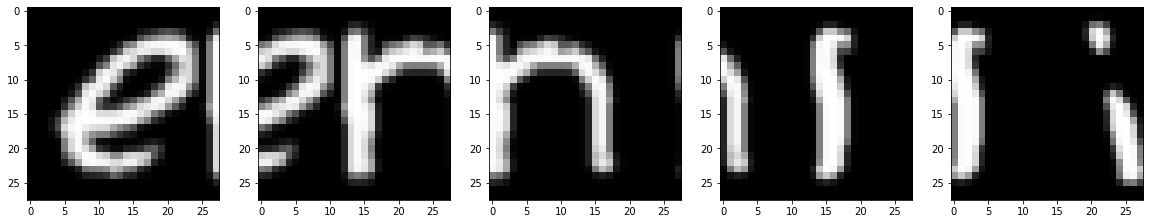

In [20]:
fig = plt.figure(figsize=(20, 20))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(patches[i].squeeze(0), cmap='gray')

# Testing the data loader for EmnistLines

In [21]:
from text_recognizer.datasets.util import fetch_data_loaders

In [22]:
dls = fetch_data_loaders(["train"], "EmnistLinesDataset", {}, batch_size=16, shuffle=True, cuda=False)

2020-08-11 19:28:39.339 | DEBUG    | text_recognizer.datasets.emnist_lines_dataset:_load_data:159 - EmnistLinesDataset loading data from HDF5...


In [23]:
dl = dls["train"]

In [24]:
d, t = next(iter(dl))

In [25]:
d.shape

torch.Size([16, 1, 28, 952])

In [26]:
t.shape

torch.Size([16, 34])

In [27]:
patches = sliding_window(images=d, patch_size=(28, 28), stride=(1, 14))

In [28]:
patches.shape

torch.Size([16, 67, 1, 28, 28])

and the washedout final___________


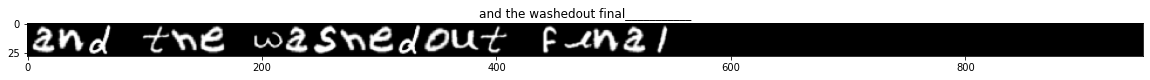

In [32]:
plt.figure(figsize=(20, 20))
sentence = convert_y_label_to_string(t[0].numpy()) 
print(sentence)
plt.title(sentence)
plt.imshow(d[0, 0], cmap='gray')

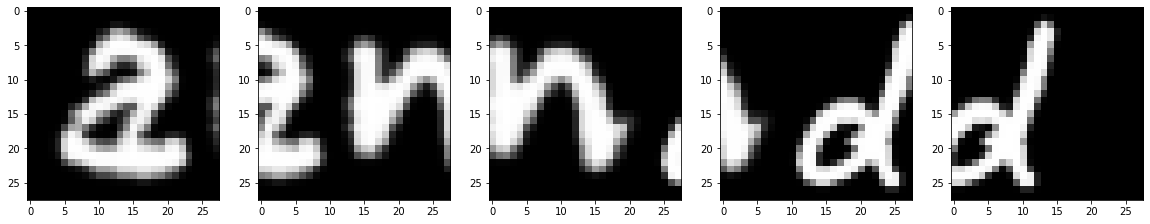

In [30]:
fig = plt.figure(figsize=(20, 20))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(patches[0, i].squeeze(0), cmap='gray')

# Reshape patches for passing through a CNN

In [33]:
from einops import rearrange

In [34]:
x = rearrange(patches, "b t c h w -> (b t) c h w")

In [35]:
x.shape

torch.Size([1072, 1, 28, 28])

In [36]:
from torch import nn

In [38]:
cnn = nn.Conv2d(1, 16, 3, 3)

In [39]:
xx = cnn(x)

In [40]:
xx.shape

torch.Size([1072, 16, 9, 9])

In [44]:
h = rearrange(xx, "(b t) c h w -> (b t) (c h w)", b = 16, t=67)

In [41]:
h = rearrange(xx, "(b t) c h w -> b t (c h w)", b = 16, t=67)

In [45]:
h.shape

torch.Size([1072, 1296])

In [46]:
l = nn.Linear(1296, 128)

In [47]:
hh = l(h)

In [48]:
hh.shape

torch.Size([1072, 128])

In [54]:
hhh = rearrange(hh, "(b t) h -> t b h", b = 16, t=67)

In [55]:
hhh.shape

torch.Size([67, 16, 128])

In [58]:
rnn = nn.LSTM(128, 64)

In [59]:
h0 = torch.randn(1, 16, 64)
c0 = torch.randn(1, 16, 64)

In [60]:
output, (hn, cn) = rnn(hhh, (h0, c0))

In [61]:
output.shape

torch.Size([67, 16, 64])